# Cubed: an introduction

Tom White, November 2024

# Idea

Use Zarr as the underlying intermediate persistent storage between array operations.

![Cubed idea](cubed-idea.svg)

Tasks operate on Zarr chunks.

Tasks are embarassingly parallel, and their runtime memory can be tightly controlled.

# Demo

Cubed implements the [Python Array API standard](https://data-apis.org/array-api/latest/)

In [1]:
import cubed.array_api as xp
a = xp.asarray([[1, 2, 3], [4, 5, 6], [7, 8, 9]], chunks=(2, 2))

Notice that we specify chunks, just like in Dask Array.

In [2]:
b = xp.asarray([[1, 1, 1], [1, 1, 1], [1, 1, 1]], chunks=(2, 2))
c = xp.add(a, b)

Cubed uses lazy evaluation, so nothing has been computed yet.

In [3]:
c.compute()

array([[ 2,  3,  4],
       [ 5,  6,  7],
       [ 8,  9, 10]])

# Primitives

* __Blockwise__: applies a function to multiple blocks from multiple inputs
* __Rechunk__: changes chunking, without changing shape/dtype

Dask introduced both of these operations.

__Almost all__ array operations can be implemented using these two primitives!

# Design

Cubed is composed of five layers: from the storage layer at the bottom, to the Array API layer at the top: 

![Five layer diagram](../../images/design.svg)

# Core and Primitive Operations

![Core and Primitive Operations](../../images/ops.dot.svg)

# Example: `map_selection`

![`map_direct`](../../images/map_selection.svg)

Each block in the output array is read directly from one or more blocks from the input.

Can cross block boundaries.

# Example: `reduction`

![`reduction`](../../images/reduction_new.svg)

Implemented using multiple rounds of a tree reduce operation followed by a final aggregation.

# Computation plan

Cubed creates a computation _plan_, which is a directed acyclic graph (DAG).

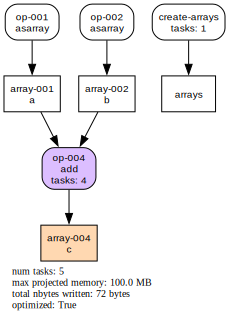

In [4]:
c = xp.add(a, b)
c.visualize()

Unlike a Dask graph which is at the task level, a Cubed graph is at the Zarr array level.

# Optimization

Cubed will automatically optimize the graph before computing it. For example by fusing blockwise (map) operations:

<p float="left">
  <img src="toy-unoptimized.png" height="600" />
  <img src="toy-optimized.png" height="600"/>
</p>

# Optimization: an advanced example

In early 2024 we implemented more optimizations to give a **4.8x** performance improvement on the "Quadratic Means" climate workload running on Lithops with AWS Lambda, with a **1.5 TB** workload completing in around **100 seconds**

<img src="benchmarks-aws.png" width="600">

More details in [Optimizing Cubed](https://medium.com/pangeo/optimizing-cubed-7a0b8f65f5b7)


# Memory

Cubed models the memory used by every operation, and calculates the `projected_mem` for a task - an upper bound.

<img src="../../images/memory.svg" width="600">

If projected memory is more than what user specifies is allowed then an exception is raised __during planning__

In [5]:
import cubed
spec = cubed.Spec(work_dir="tmp", allowed_mem=100)  # not enough memory!
a = xp.asarray([[1, 2, 3], [4, 5, 6], [7, 8, 9]], chunks=(2, 2), spec=spec)
b = xp.asarray([[1, 1, 1], [1, 1, 1], [1, 1, 1]], chunks=(2, 2), spec=spec)
try:
    c = xp.add(a, b)
except ValueError as e:
    print(e)

Projected blockwise memory (192) exceeds allowed_mem (100), including reserved_mem (0)


# Peak memory

Cubed measures the peak amount of memory actually used during runtime.

Used to checked utilization, and improve the modelling.

```
  array_name    op_name  num_tasks  peak_mem_delta_mb_max  projected_mem_mb  utilization
0  array-003    rechunk          1             103.727104         0.000064          NaN
1  array-004  blockwise          4             654.286848       800.000008     0.817859
2  array-007    rechunk          1             103.645184         0.000064          NaN
3  array-008  blockwise          4             654.364672       800.000008     0.817956
4  array-009  blockwise          4             796.954624      1200.000000     0.664129
```


# Runtimes

* __Lithops__: multi-cloud serverless computing framework
    * Slightly more work to get started since you have to build a runtime environment first
    * Tested on AWS Lambda and Google Cloud Functions with ~1000 workers

* __Modal__: a commercial serverless platform
    * Very easy to set up since it builds the runtime automatically
    * Tested with ~300 workers

* __Apache Beam (Google Cloud Dataflow)__: fully managed pipeline processing service
    * Slow to spin up
    * Only tested with ~20 workers, but very mature so will scale out

# Example timeline

Adding two 20GB arrays on Lithops (AWS Lambda)

![Lithops timeline](cubed-lithops-timeline.png)

# Scalability and robustness

* Serverless scales out
    * AWS Lambda supports 1000 concurrent instances by default
    * PyWren paper: [https://shivaram.org/publications/pywren-socc17.pdf](https://shivaram.org/publications/pywren-socc17.pdf)
* Retries
    * Each task is tried three times before failing
* Stragglers
    * A backup task will be launched if a task is taking significantly longer than average

# Xarray integration

* Xarray can use Cubed as its computation engine instead of Dask
    * Just install the [cubed-xarray](https://github.com/xarray-contrib/cubed-xarray) integration package
* Cubed can use [Flox](https://flox.readthedocs.io/en/latest/) for `groupby` operations
    * Examples at https://flox.readthedocs.io/en/latest/user-stories/climatology-hourly-cubed.html

# Try out Cubed!

* Try it out on your use case
    * Get started at https://cubed-dev.github.io/cubed/
* Some examples from the Pangeo community:
    * https://github.com/pangeo-data/distributed-array-examples